# Laboratorio 7: Poke-ensambles

**Duración:** 2 horas  
**Formato:** Competencia por equipos con rotaciones y
kahoots Pokemon  
**Repositorio base:** [_link al repo oficial_](https://github.com/JAlbertoAlonso/poke-ensambles/tree/main)

---

## Portada del equipo

**Integrantes:**
- Erick Yair Aguilar Martinez (https://github.com/Eickyair)
- Luis Enrique Villalon Pineda (https://github.com/enriquevillalon17)
- Imanol Mendoza Saenz de Buruaga (Usuario GitHub)

**Repositorio del equipo:**
<https://github.com/usuario/equipoX>

**Fecha de entrega:**
25/10/2025

## Elemento 1 - Construcción del dataset (Infraestructura)

In [1]:
try:
    from theme import use_tokyo
    use_tokyo()
except Exception:
    pass
import pandas as pd
from utils import fetch_all_pokemons
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np
import os
PATH_TRAIN = os.path.join(".", "train.csv")
PATH_TEST = os.path.join(".", "test.csv")

In [2]:
pokemons = await fetch_all_pokemons()
pokemons = pd.DataFrame(pokemons)
pokemons = pokemons.sort_values("id").reset_index(drop=True)
pokemons.head()

,id,name,weight,height,base_experience,type_main,hp,attack,defense,special_attack,special_defense,speed
0,1,bulbasaur,69,7,64,grass,45,49,49,65,65,45
1,2,ivysaur,130,10,142,grass,60,62,63,80,80,60
2,3,venusaur,1000,20,236,grass,80,82,83,100,100,80
3,4,charmander,85,6,62,fire,39,52,43,60,50,65
4,5,charmeleon,190,11,142,fire,58,64,58,80,65,80


In [3]:
stat_columns = [
    'hp',
    'attack',
    'defense',
    'special_attack',
    'special_defense',
    'speed'
]
pokemons['power_score'] = pokemons[stat_columns].sum(axis=1)

percentil_75_ps = pokemons['power_score'].quantile(0.75)
pokemons['strong'] = (pokemons['power_score'] >= percentil_75_ps).astype(int)
pokemons_plot = pokemons.copy()
pokemons_plot.columns = [
    'ID',
    'Nombre',
    'Peso',
    'Altura',
    'Experiencia Base',
    'Tipo Principal',
    'HP',
    'Ataque',
    'Defensa',
    'Ataque Especial',
    'Defensa Especial',
    'Velocidad',
    'Puntaje de Poder',
    'Fuerte'
]
pokemons_plot['Fuerte'] = pokemons_plot['Fuerte'].map({0: 'Débil', 1: 'Fuerte'})
muestreo_aleatorio = pokemons_plot.sample(500, random_state=1<<9)
pokemons.sample(10, random_state=1<<9)

,id,name,weight,height,base_experience,type_main,hp,attack,defense,special_attack,special_defense,speed,power_score,strong
651,652,chesnaught,900,16,239,grass,88,107,122,74,75,64,530,1
54,55,golduck,766,17,175,water,80,82,78,95,80,85,500,0
943,944,shroodle,7,2,58,poison,40,65,35,40,35,75,290,0
527,528,swoobat,105,9,149,psychic,67,57,55,77,55,114,425,0
381,382,kyogre,3520,45,302,water,100,100,90,150,140,90,670,1
12,13,weedle,32,3,39,bug,40,35,30,20,20,50,195,0
982,983,kingambit,1200,20,275,dark,100,135,120,60,85,50,550,1
108,109,koffing,10,6,68,poison,40,65,95,60,45,35,340,0
595,596,galvantula,143,8,165,bug,70,77,60,97,60,108,472,0
814,815,cinderace,330,14,265,fire,80,116,75,65,75,119,530,1


Lo primero a considerar es que en los siguientes análisis exploratorios no indagaremos en ningún momento en los patrones existentes entre las variables 'Peso', 'Altura', 'Tipo' y 'Experiencia' con 'HP', 'Ataque', 'Defensa', ... 'Puntaje de Poder', porque en un escenario real esas variables serían ocultas para nosotros. Unicamente nos centraremos en la etiqueta y las variables definidas

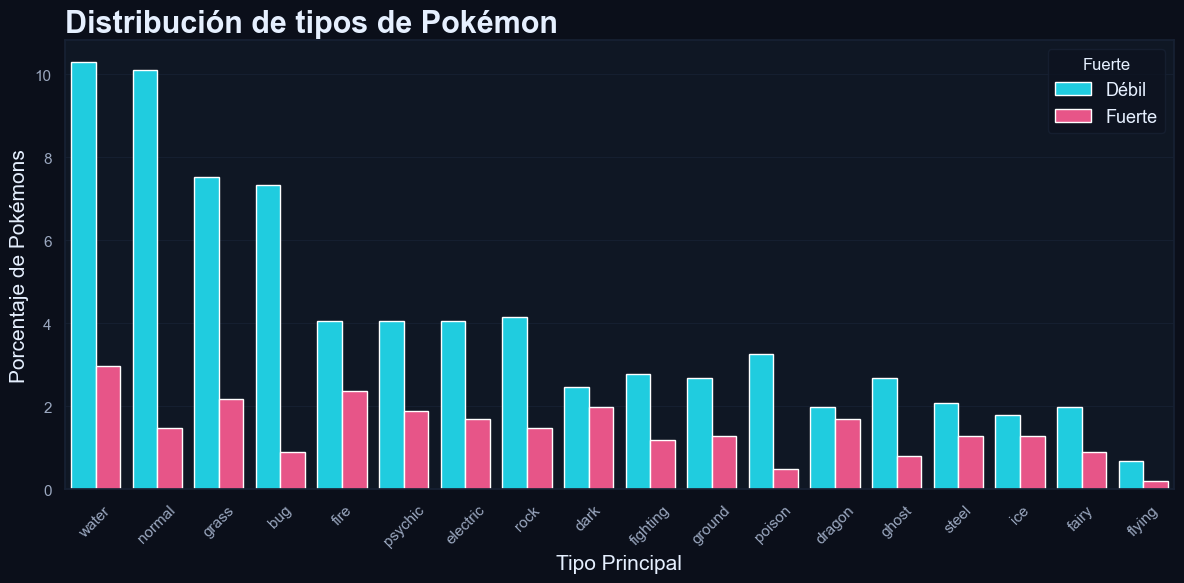

In [4]:
plt.figure(figsize=(12,6))
sns.countplot(
    data=pokemons_plot,
    x='Tipo Principal',
    order=pokemons_plot['Tipo Principal'].value_counts().index,
    hue='Fuerte',
    stat='percent'
)
plt.xticks(rotation=45)
plt.title("Distribución de tipos de Pokémon")
plt.ylabel("Porcentaje de Pokémons")
plt.show()

Como puede verse, si tomamos de manera aleatoria 500 pokemons, es probable que la distribución de clases se mantenga, por lo que tendríamos un desbanco de ellas. A continuación se muestra un ejemplo con 200 muestreos aleatorios.

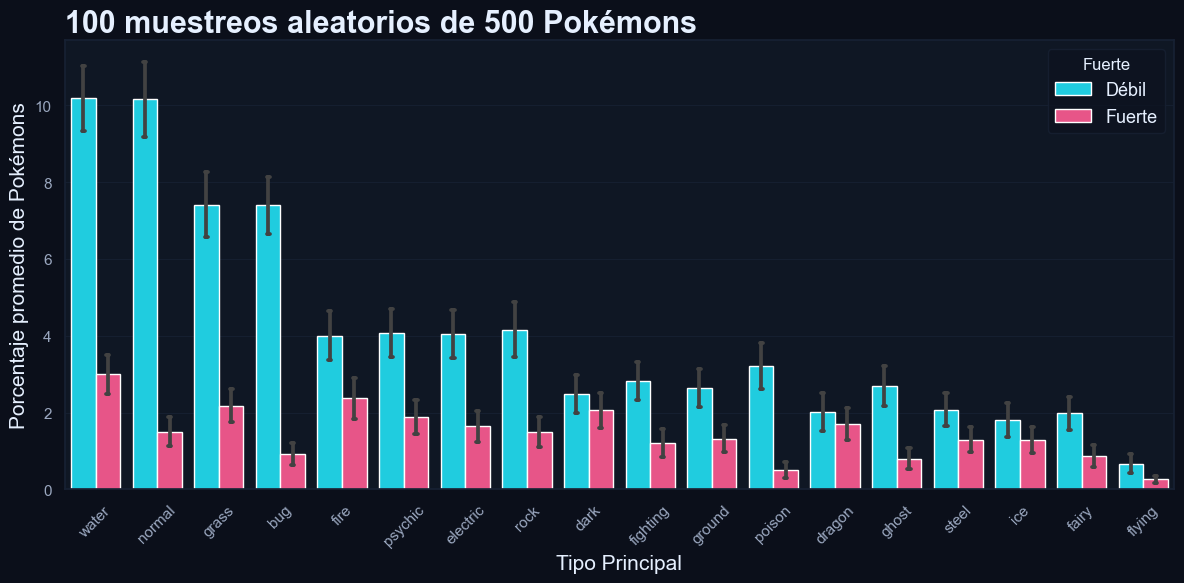

In [5]:
semilla_muestreo_aletorio = 1<<11
num_muestras = 200
promedios_tipo = []
for i in range(num_muestras):
    muestra = pokemons_plot.sample(
        500,
        replace=False,
        random_state=semilla_muestreo_aletorio + i
    )
    conteo_tipo_muestra = muestra.groupby(
        ['Tipo Principal', 'Fuerte']
    ).size().reset_index(
        name='Cantidad'
    )
    # Calcular porcentaje en lugar de cantidad absoluta
    total_muestra = muestra.shape[0]
    conteo_tipo_muestra['Porcentaje'] = (conteo_tipo_muestra['Cantidad'] / total_muestra) * 100
    conteo_tipo_muestra['Muestra'] = i
    promedios_tipo.append(conteo_tipo_muestra)

# Concatenar todas las muestras
promedios_tipo = pd.concat(promedios_tipo, ignore_index=True)
plt.figure(figsize=(12,6))
sns.barplot(
    data=promedios_tipo,
    x='Tipo Principal',
    y='Porcentaje',
    hue='Fuerte',
    errorbar='sd',
    capsize=0.1,
    order=pokemons_plot['Tipo Principal'].value_counts().index,
)
plt.xticks(rotation=45)
plt.title("100 muestreos aleatorios de 500 Pokémons")
plt.ylabel("Porcentaje promedio de Pokémons")
plt.show()

Por lo anterior optamos no hacer un muestreo aleatorio simple, pero aparte notamos algo que es mas o menos tribial. Por naturaleza el dataset esta y estara desbalanceado siempre entre la clase `Debil` y `Fuerte` pues la forma en que calculamos estas etiquetas provoca que 25% de toda la población de pokemons sean fuertes mientras que el 75% restante no. Lo siguiente entonces seria averiguar si el tipo de un pokemon tiene efectos sobre si es considerado fuerte o debil.

In [6]:

df_cont = pokemons_plot.copy()
df_cont['Fuerte'] = df_cont['Fuerte'].map({'Débil': 0, 'Fuerte': 1})
df_cont['Tipo Principal'] = df_cont['Tipo Principal'].astype('category')

tabla_contingencia = pd.crosstab(df_cont['Tipo Principal'], df_cont['Fuerte'])
display(tabla_contingencia.head(10))
chi2_stat, p, dof, expected = chi2_contingency(tabla_contingencia, correction=False)

exp = pd.DataFrame(expected, index=tabla_contingencia.index, columns=tabla_contingencia.columns)

ok_5 = (exp.values >= 5).mean() >= 0.80
ok_1 = (exp.values >= 1).all()

print(f"≥5 en ≥80% de celdas: {ok_5} | ninguna <1: {ok_1}")
chi2_stat, p, dof, expected = chi2_contingency(tabla_contingencia, correction=False)
print(f"χ² = {chi2_stat:.3f}, gl = {dof}, p-valor = {p:.6f}")


n = tabla_contingencia.values.sum()
min_dim = min(tabla_contingencia.shape) - 1
cramers_v = np.sqrt(chi2_stat / (n * min_dim))
print(f"Cramér's V = {cramers_v:.3f}")


Fuerte,0,1
Tipo Principal,,
bug,74,9
dark,25,20
dragon,20,17
electric,41,17
fairy,20,9
fighting,28,12
fire,41,24
flying,7,2
ghost,27,8


≥5 en ≥80% de celdas: True | ninguna <1: True
χ² = 54.776, gl = 17, p-valor = 0.000007
Cramér's V = 0.233



- Con **χ²(17) = 54.776** y **p = 0.000007**, se **rechaza H₀** de independencia entre *Tipo Principal* y *Fuerte/Débil*.  
- Por lo tanto, existe asociación estadísticamente significativa: el tipo principal SÍ influye en la probabilidad de que un Pokémon sea considerado fuerte.
- El tamaño de efecto es Cramér’s V = 0.233, lo que indica una asociación de magnitud pequeña a moderada (relevante pero no determinante por sí sola).
- Algunos tipos presentan más (o menos) Pokémon fuertes de lo esperado.


In [7]:
obs = tabla_contingencia.values
exp = expected
std_resid = (obs - exp) / np.sqrt(exp)
std_resid_df = pd.DataFrame(std_resid, index=tabla_contingencia.index, columns=tabla_contingencia.columns)
std_resid_df

Fuerte,0,1
Tipo Principal,,
bug,1.609813,-2.713050
dark,-1.435617,2.419475
dragon,-1.407968,2.372877
electric,-0.289641,0.488138
fairy,-0.312769,0.527117
fighting,-0.291252,0.490853
fire,-1.020292,1.719519
flying,0.133164,-0.224424
ghost,0.218926,-0.368961


Con la anterior, podemos ver que para el tipo `dark` parece ser que hay bastantes mas `Fuertes` de lo esperado y naturalmente menos `Debiles`. En el caso de `bug` es lo contrario, hay mas `Debiles` de lo esperado.

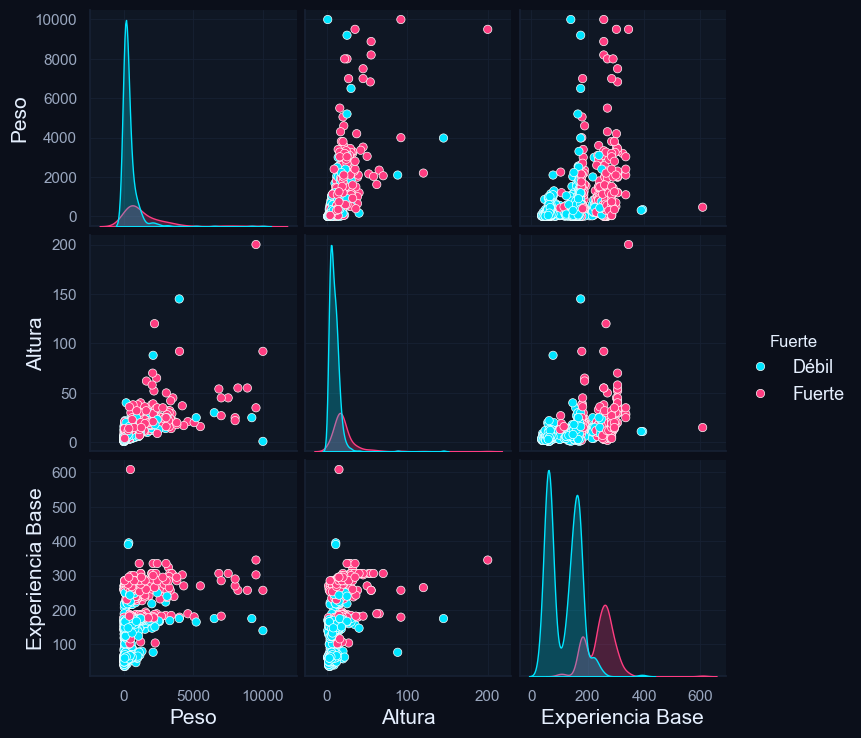

In [8]:
sns.pairplot(
    pokemons_plot,
    hue='Fuerte',
    vars=['Peso', 'Altura', 'Experiencia Base']
)
plt.show()

En la anterior visualización podemos observar que hay unos cuantos *outliers* principalmente en la variable de peso, pero indagaremos variable por variable como se comportan las clases

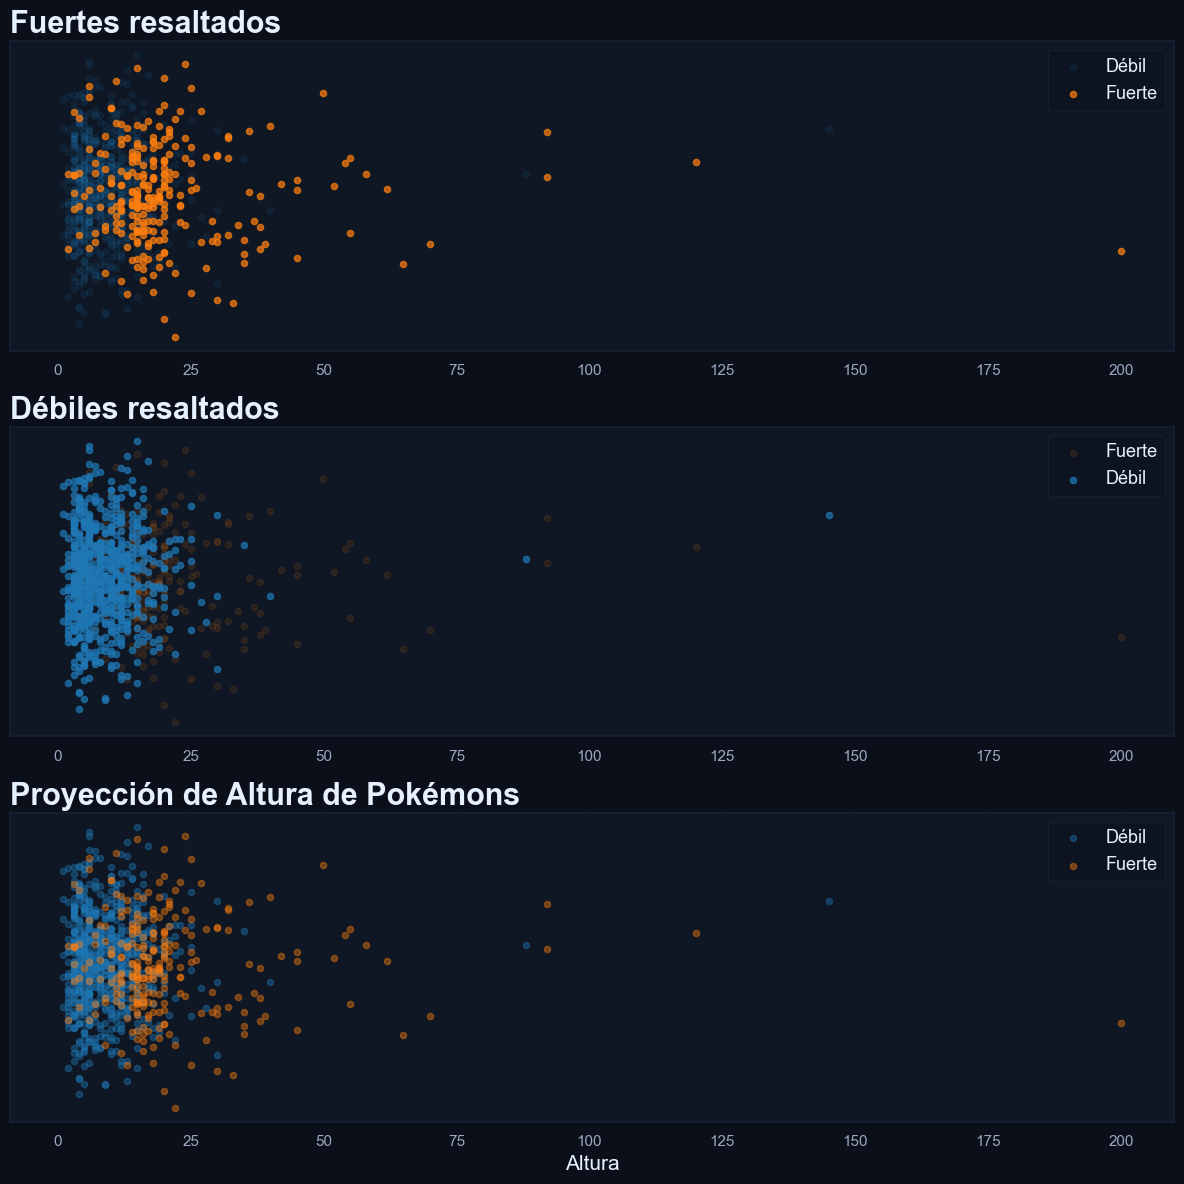

In [9]:
from utils import plot_distribution
plot_distribution(
    pokemons_plot,
    'Altura'
)

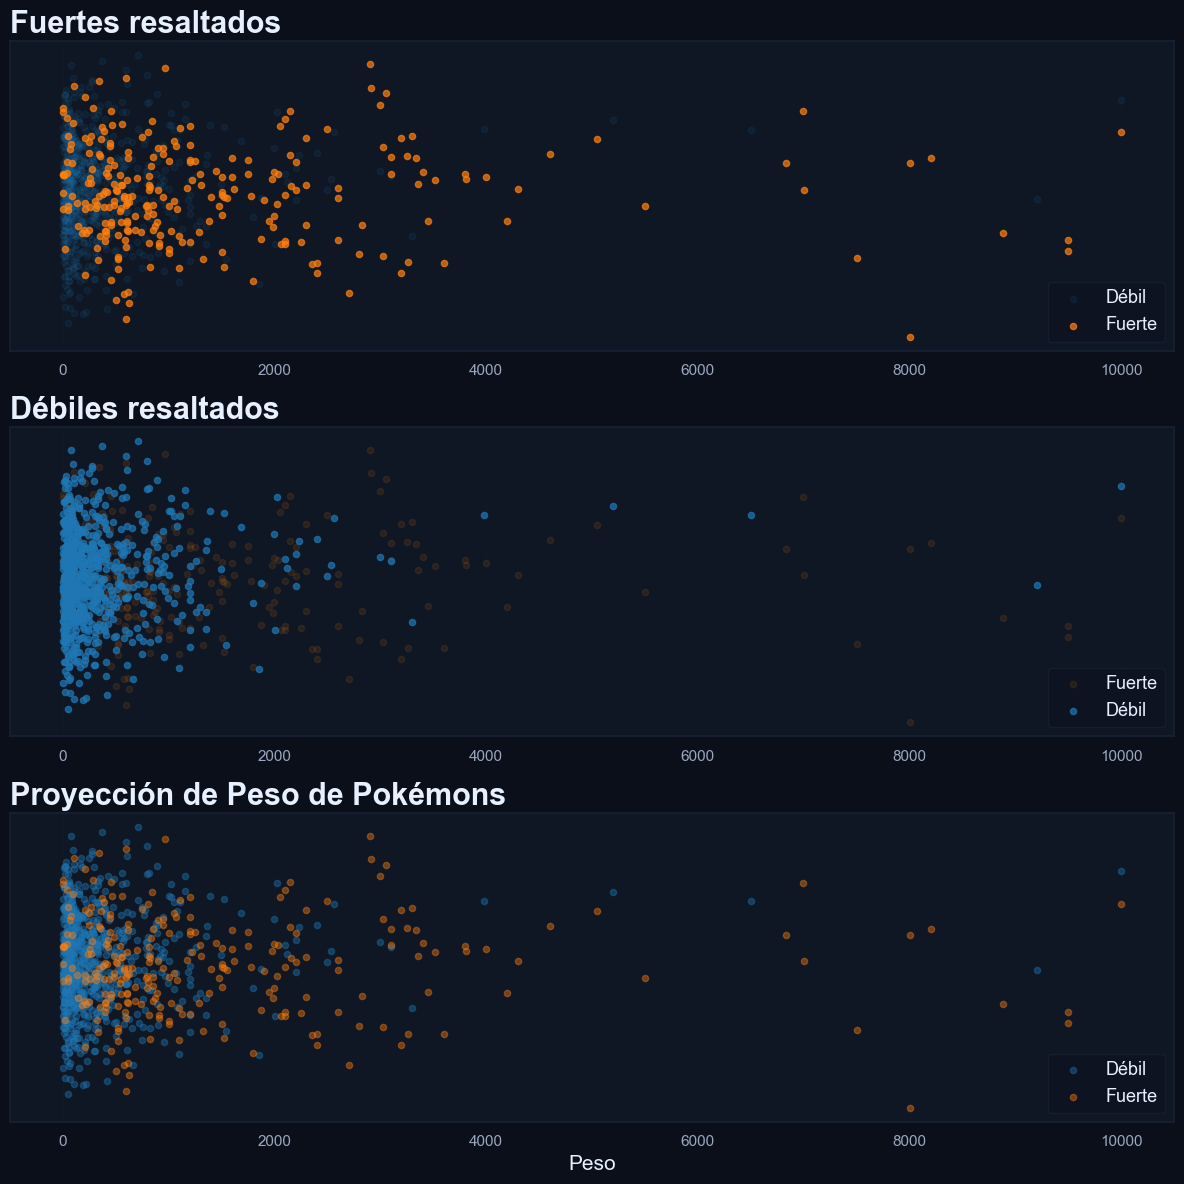

In [10]:
plot_distribution(
    pokemons_plot,
    'Peso'
)

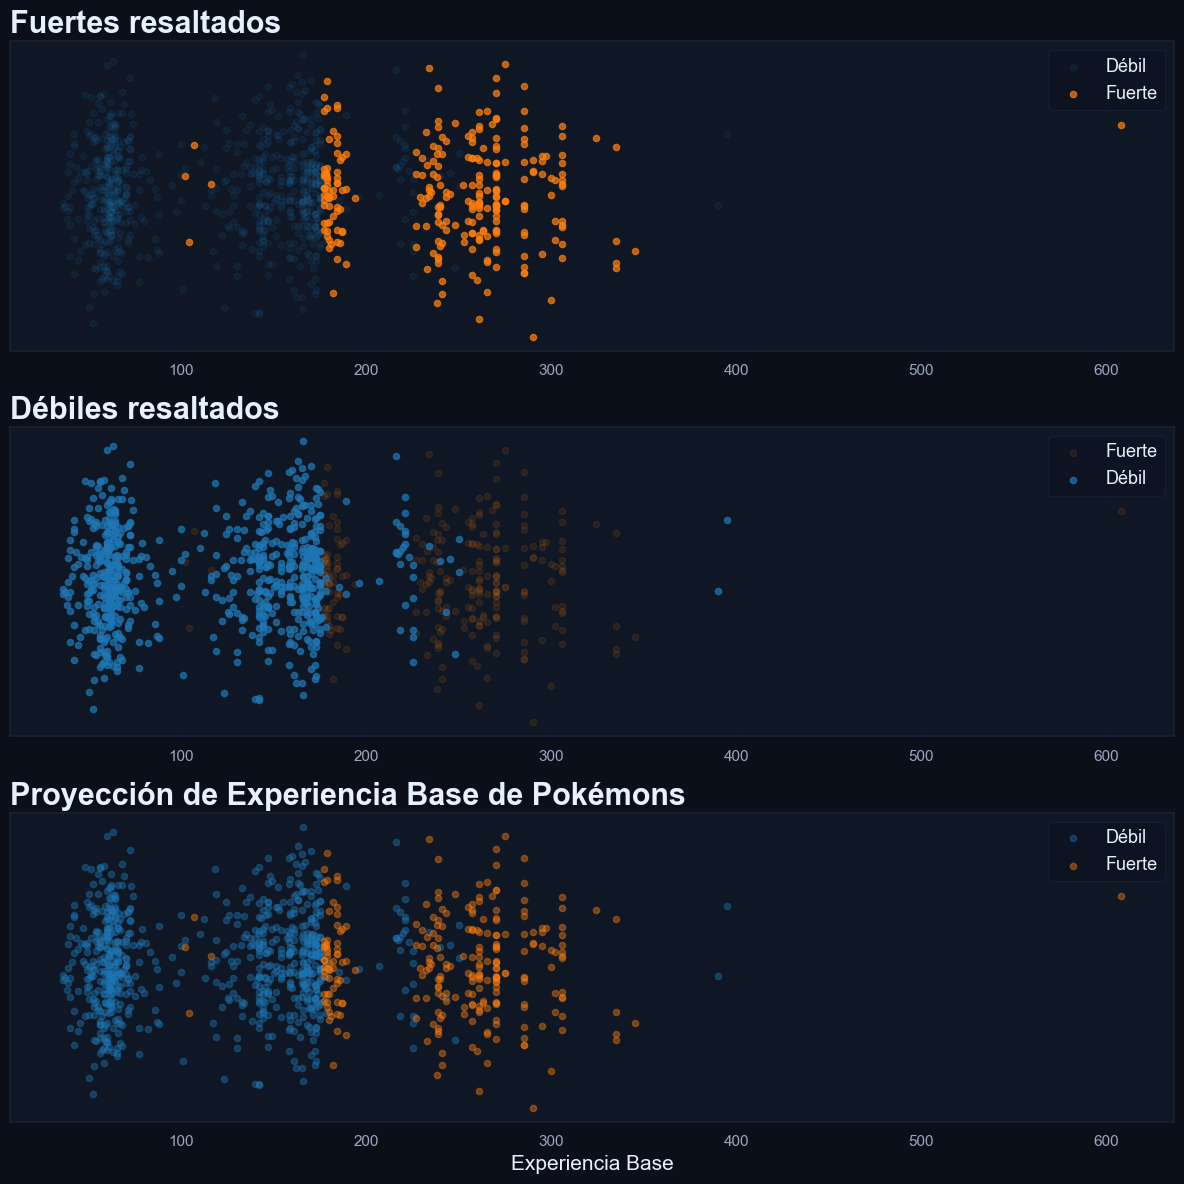

In [11]:
plot_distribution(
    pokemons_plot,
    'Experiencia Base'
)

Considerando lo anterior es claro que:
- Hay *outliers*
- No es realizable bajo separadores lineales, para mismos valores en características(de momento sin considerar el tipo) puede ser Débil o Fuerte
- Mientras mayor son los valores de estas características se puede apreciar que hay una mayor proporción de fuertes
- La experiencia base parece ser la que mejor separa a los dos conjuntos

# Eliminamos outliers y Muestreando

In [12]:
std_peso = pokemons_plot['Peso'].std()
std_altura = pokemons_plot['Altura'].std()
std_experiencia = pokemons_plot['Experiencia Base'].std()
outlier_mask = (
    (np.abs(pokemons_plot['Peso'] - pokemons_plot['Peso'].mean()) > 3 * std_peso) |
    (np.abs(pokemons_plot['Altura'] - pokemons_plot['Altura'].mean()) > 3 * std_altura) |
    (np.abs(pokemons_plot['Experiencia Base'] - pokemons_plot['Experiencia Base'].mean()) > 3 * std_experiencia)
)
pokemons_cleaned = pokemons_plot[~outlier_mask].reset_index(drop=True)
eliminados = pokemons_plot.shape[0] - pokemons_cleaned.shape[0]
print(f"Pokémons eliminados por outliers: {eliminados}")

Pokémons eliminados por outliers: 32


## Muestreo 'Justo'

In [13]:
N = 500

df = pokemons_cleaned.copy()
y_text = df['Fuerte'].astype(str)
df['Fuerte_bin'] = (y_text.str.lower() == 'fuerte').astype(int)
df['Tipo Principal'] = df['Tipo Principal'].astype('category')

tabla = pd.crosstab(df['Tipo Principal'], df['Fuerte_bin'])
chi2_stat, p, dof, expected = chi2_contingency(tabla, correction=False)
exp = pd.DataFrame(expected, index=tabla.index, columns=tabla.columns)

std_resid = (tabla.values - expected) / np.sqrt(expected)
Z = pd.DataFrame(std_resid, index=tabla.index, columns=tabla.columns)

tipos = tabla.index.tolist()
T = len(tipos)

base = N // T
resto = N - base*T
n_t = pd.Series(base, index=tipos)

orden = Z[1].abs().sort_values(ascending=False).index.tolist()
for t in orden[:resto]:
    n_t[t] += 1

p_global = df['Fuerte_bin'].mean()

BETA = 0.0
ZCAP = 3.0

def p_target(z1, p0=p_global, beta=BETA, zcap=ZCAP):
    adj = - beta * (np.clip(z1, -zcap, zcap) / zcap)
    return float(np.clip(p0 + adj, 0.05, 0.95))

p_t = Z[1].apply(p_target)

# ---------- muestreo guiado por p_t ----------
rng = np.random.default_rng(42)
train_idxs = []

for t in tipos:
    sub = df[df['Tipo Principal'] == t]
    pos = sub[sub['Fuerte_bin'] == 1]
    neg = sub[sub['Fuerte_bin'] == 0]

    n = int(n_t[t])
    q_pos = int(round(p_t[t] * n))
    q_pos = max(0, min(q_pos, n))

    k_pos = min(q_pos, len(pos))
    k_neg = min(n - q_pos, len(neg))

    pos_sample = pos.sample(k_pos, replace=(k_pos > len(pos)), random_state=42)
    neg_sample = neg.sample(k_neg, replace=(k_neg > len(neg)), random_state=42)

    faltan = n - len(pos_sample) - len(neg_sample)
    if faltan > 0:
        escasa = pos if len(pos) < len(neg) else neg
        extra = escasa.sample(faltan, replace=True, random_state=42)
        train_idxs.append(extra.index)

    train_idxs.extend([pos_sample.index, neg_sample.index])

train_idxs = pd.Index(np.concatenate([np.asarray(i) for i in train_idxs]))
train = df.loc[train_idxs].reset_index(drop=True)

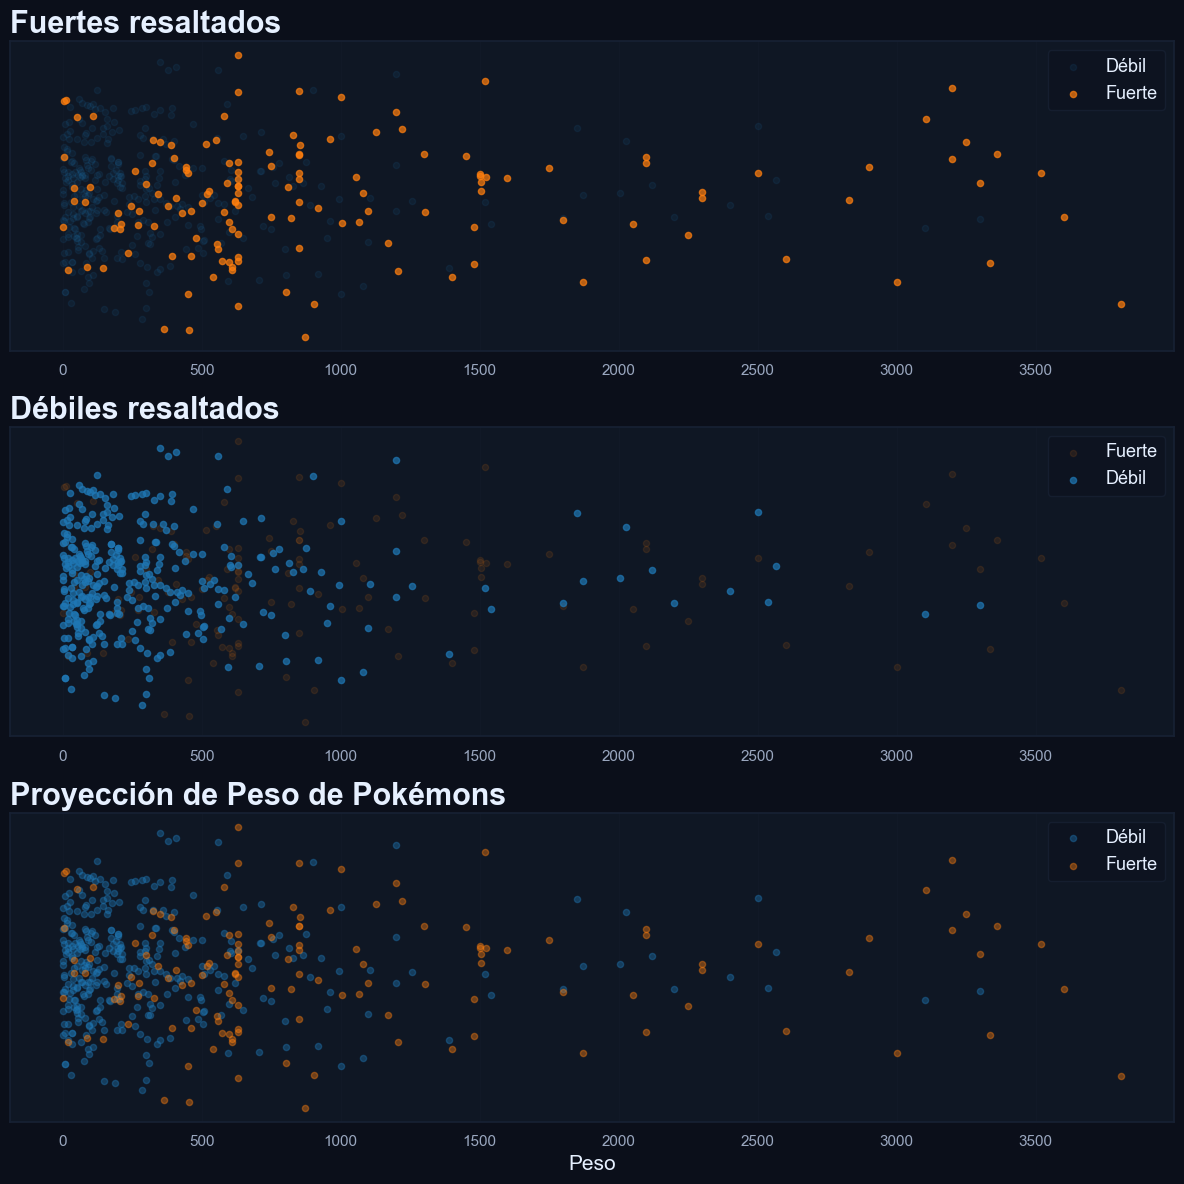

In [14]:
plot_distribution(
    train,
    'Peso'
)

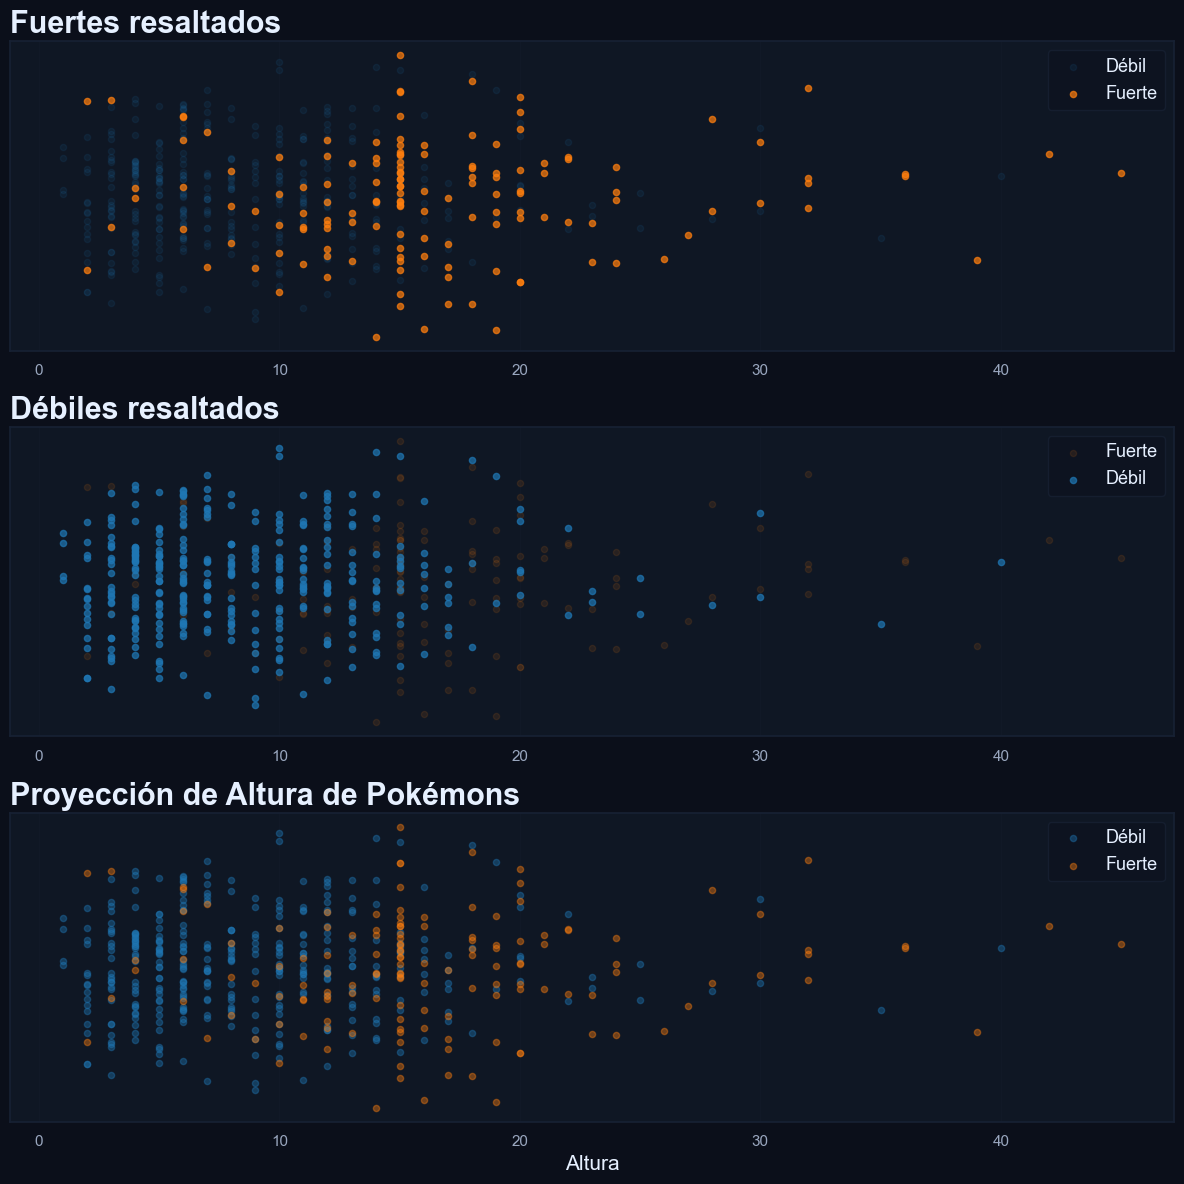

In [15]:
plot_distribution(
    train,
    'Altura'
)

## Conjunto de Prueba

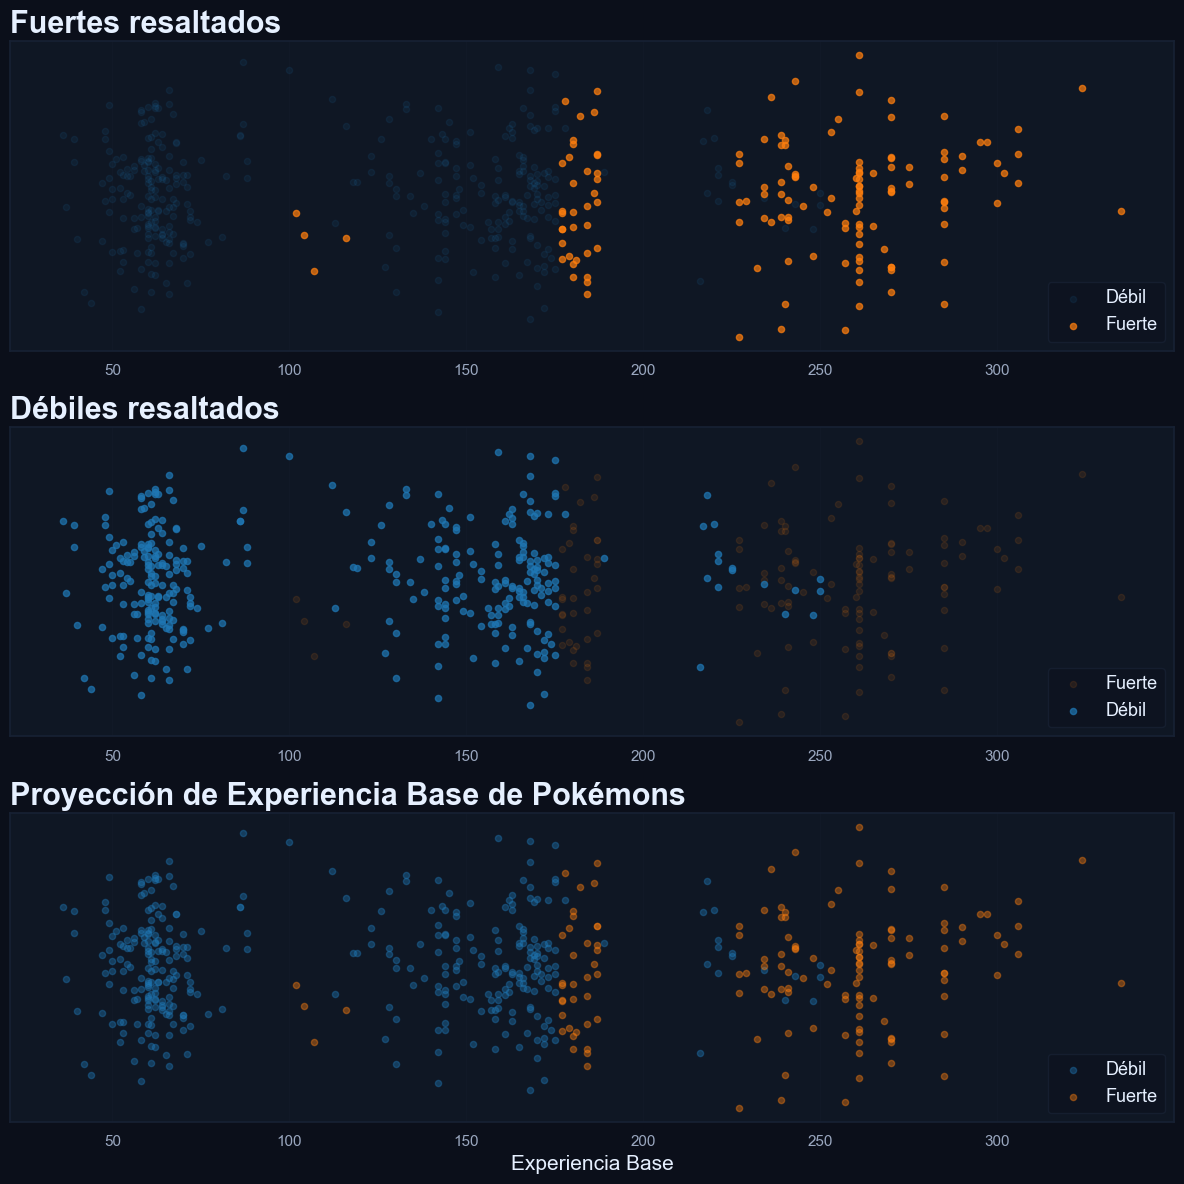

In [16]:
plot_distribution(
    train,
    'Experiencia Base'
)

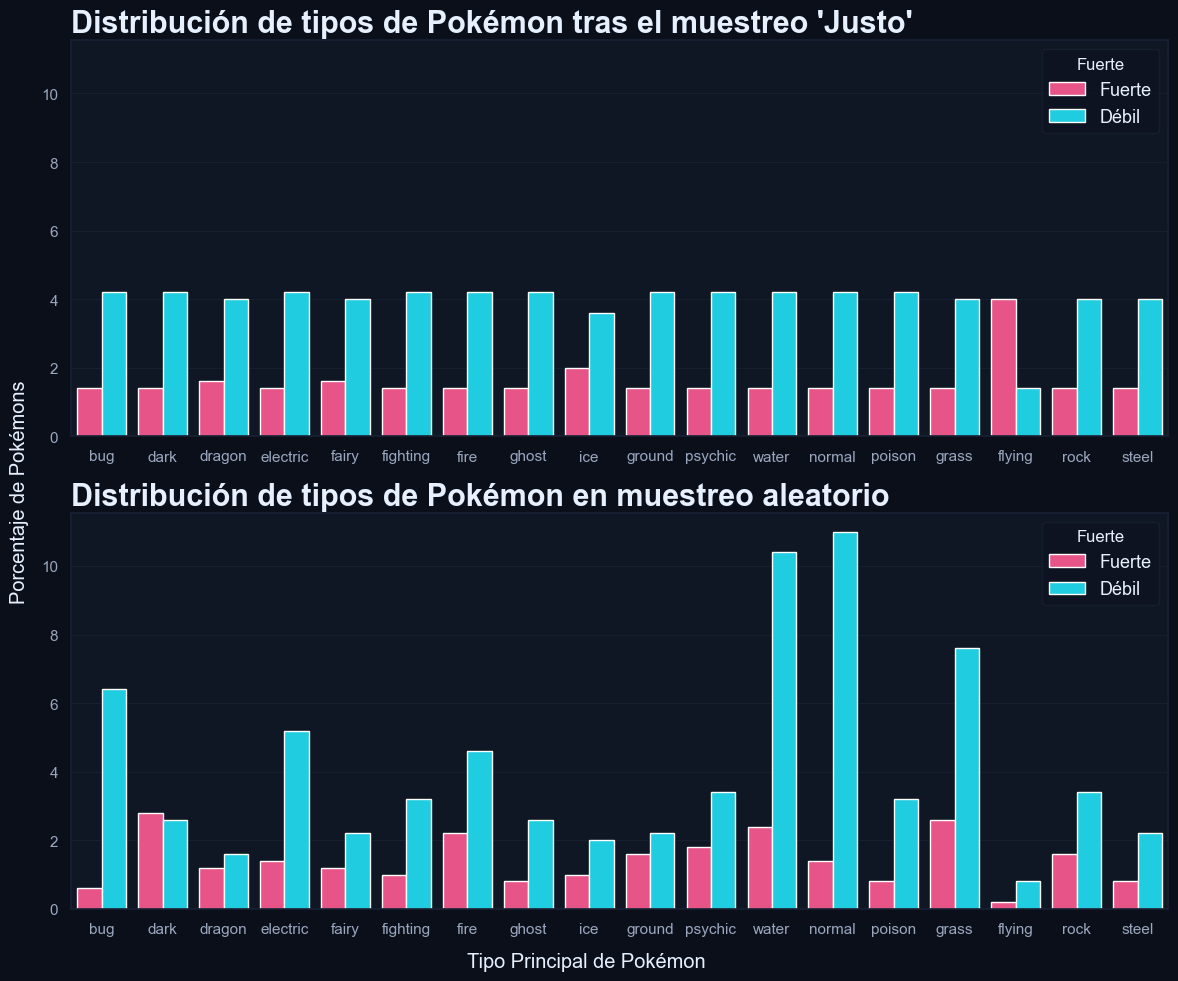

In [17]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(12, 10),
    sharey=True
)
sns.countplot(
    data=train,
    x='Tipo Principal',
    order=train['Tipo Principal'].value_counts().index,
    hue='Fuerte',
    stat='percent',
    # color
    palette={'Débil': '#00e5ff', 'Fuerte': '#ff3d81'},
    ax=ax[0]
)
order = train['Tipo Principal'].value_counts().index
ax[0].set_title("Distribución de tipos de Pokémon tras el muestreo 'Justo'")
ax[0].set_ylabel("")
ax[0].set_xlabel("")
sns.countplot(
    data=muestreo_aleatorio,
    x='Tipo Principal',
    order=order,
    hue='Fuerte',
    stat='percent',
    # color
    palette={'Débil': '#00e5ff', 'Fuerte': '#ff3d81'},
    ax=ax[1]
)
ax[1].set_title("Distribución de tipos de Pokémon en muestreo aleatorio")
ax[1].set_ylabel("")
ax[1].set_xlabel("")
fig.supxlabel("Tipo Principal de Pokémon", y=0.02)
fig.supylabel("Porcentaje de Pokémons", x=0.02)
plt.tight_layout()
plt.show()

In [18]:
train_to_export = train.copy()
train_to_export.rename(columns={
    'ID': 'id',
    'Nombre': 'name',
    'Peso': 'weight',
    'Altura': 'height',
    'Experiencia Base': 'base_experience',
    'Tipo Principal': 'type_main',
    'HP': 'hp',
    'Ataque': 'attack',
    'Defensa': 'defense',
    'Ataque Especial': 'special_attack',
    'Defensa Especial': 'special_defense',
    'Velocidad': 'speed',
    'Puntaje de Poder': 'power_score',
    'Fuerte': 'strong'
}, inplace=True)
train_to_export['strong'] = (train_to_export['strong'] == 'Fuerte').astype(int)
train_to_export.to_csv(PATH_TRAIN, index=False)

## Elemento 2 - Entrenamiento de modelos base (Modelado)

### SVM

In [19]:
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [20]:
testset_df = pd.read_csv("https://raw.githubusercontent.com/JAlbertoAlonso/poke-ensambles/refs/heads/main/data/testset.csv")
print(testset_df.shape)
testset_with_labels = testset_df.merge(
    pokemons_cleaned[['ID', 'Fuerte']],
    left_on='id',
    right_on='ID',
    how='left'
).drop(columns=['ID'])
testset_with_labels.rename(columns={
    'Fuerte': 'strong'
}, inplace=True)
testset_with_labels['strong'] = (testset_with_labels['strong'] == 'Fuerte').astype(int)
testset_with_labels.to_csv(PATH_TEST, index=False)

(120, 12)


In [21]:
def make_preprocessor():
    numeric = Pipeline([
        ("scaler", StandardScaler())
    ])
    categorical = Pipeline([
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
    ])
    preprocessor = ColumnTransformer([
        ("num", numeric, ["height", "weight", "base_experience"]),
        ("cat", categorical, ["type_main"])
    ])
    return preprocessor
features = ["height", "weight", "base_experience", "type_main"]
target = "strong"

In [22]:
features = ["height", "weight", "base_experience", "type_main"]
target = "strong"
def make_preprocessor():
    numeric = Pipeline([
        ("scaler", StandardScaler())
    ])
    categorical = Pipeline([
        # tuvimos que poner sparse_output=False
        # para que SVC funcionara sin errores
        ("onehot", OneHotEncoder(
            handle_unknown="ignore",
            sparse_output=False
        ))
    ])
    preprocessor = ColumnTransformer([
        ("num", numeric, ["height", "weight", "base_experience"]),
        ("cat", categorical, ["type_main"])
    ])
    return preprocessor
def build_models(pre):
    models = {
        "logistic": Pipeline([
            ("pre", pre),
            ("clf", LogisticRegression(max_iter=300))
        ]),
        "svm_rbf": Pipeline([
            ("pre", pre),
            ("clf", SVC(kernel="rbf", probability=True))
        ]),
        "svm_linear": Pipeline([
            ("pre", pre),
            ("clf", SVC(kernel="linear", probability=True))
        ]),
        "bayes": Pipeline([
            ("pre", pre),
            ("clf", GaussianNB())
        ]),
        "knn": Pipeline([
            ("pre", pre),
            ("clf", KNeighborsClassifier(n_neighbors=5))
        ])
    }
    return models
def train_models(models, X, y):
    for name, model in models.items():
        model.fit(X, y)
    return models
# Prediccion de probabilidades
def predict_probas(models, X):
    probas = {}
    for name, model in models.items():
        if hasattr(model.named_steps["clf"], "predict_proba"):
            probas[name] = model.predict_proba(X)[:, 1]
        else:
            dec = model.decision_function(X)
            probas[name] = (dec - dec.min()) / (dec.max() - dec.min())
    return probas


## Elemento 3 - Ensambles de votación

In [23]:
def hard_vote(label_dict):
    """Votación dura (mayoría simple)"""
    labels = np.vstack(list(label_dict.values()))
    return (labels.sum(axis=0) > labels.shape[0] / 2).astype(int)


def soft_vote(proba_dict, thr=0.5):
    """Votación suave (promedio de probabilidades)"""
    probs = np.vstack(list(proba_dict.values()))
    return (probs.mean(axis=0) >= thr).astype(int)


def weighted_vote(proba_dict, weights, thr=0.5):
    """Votación ponderada"""
    keys = list(proba_dict.keys())
    W = np.array([weights[k] for k in keys])
    P = np.vstack([proba_dict[k] for k in keys])
    score = np.average(P, axis=0, weights=W)
    return (score >= thr).astype(int)
# Pesos segun desempeño promedio en validacion cruzada
def cv_weights(models, X, y, metric="f1", cv=5):
    scores = {}
    scoring = metric if metric in ["accuracy", "f1"] else "accuracy"
    for name, model in models.items():
        s = cross_val_score(model, X, y, scoring=scoring, cv=cv).mean()
        scores[name] = max(s, 1e-6)
    total = sum(scores.values())
    return {k: v / total for k, v in scores.items()}

## Elemento 4 - Evaluación y competencia

In [24]:
def train_and_predict(train_csv, test_csv, output_csv=None):
    """
    Entrena modelos con el dataset de entrenamiento
    y predice sobre el dataset de prueba.
    Devuelve métricas de accuracy y F1 .
    """
    df_train = pd.read_csv(train_csv)
    df_test = pd.read_csv(test_csv)

    X_train = df_train[features]
    y_train = df_train[target].astype(int)

    X_test = df_test[features]
    y_test = df_test[target].astype(int) if target in df_test.columns else None

    pre = make_preprocessor()
    models = build_models(pre)
    train_models(models, X_train, y_train)


    probas_test = predict_probas(models, X_test)
    labels_test = {k: (v >= 0.5).astype(int) for k, v in probas_test.items()}

    # Votaciones
    y_hard = hard_vote(labels_test)
    y_soft = soft_vote(probas_test)
    weights = cv_weights(models, X_train, y_train)
    y_weighted = weighted_vote(probas_test, weights)

    # Guardar predicciones
    df_test["pred_hard"] = y_hard
    df_test["pred_soft"] = y_soft
    df_test["pred_weighted"] = y_weighted

    if output_csv:
        df_test.to_csv(output_csv, index=False)
        print(f" Predicciones guardadas en: {output_csv}")

    # Evaluar si tiene etiquetas reales
    if y_test is not None:
        acc_hard = accuracy_score(y_test, y_hard)
        acc_soft = accuracy_score(y_test, y_soft)
        acc_weighted = accuracy_score(y_test, y_weighted)
        f1_hard = f1_score(y_test, y_hard)
        f1_soft = f1_score(y_test, y_soft)
        f1_weighted = f1_score(y_test, y_weighted)

        metrics = pd.DataFrame({
            "Modelo": ["Votación Suave", "Votación Ponderada","Votación Dura"],
            "Accuracy": [acc_soft, acc_weighted, acc_hard],
            "F1 Score": [f1_soft, f1_weighted, f1_hard]
        })
        print("Desempeño de los ensambles:\n")
        print(metrics.to_string(index=False))
        best_model_strategy = metrics.loc[metrics['Accuracy'].idxmax()]['Modelo']
        return metrics, best_model_strategy
    else:
        print(" El CSV de prueba no tiene la columna 'strong'. Solo se generaron predicciones.")
        return None

In [25]:
train_csv = PATH_TRAIN
test_csv  = PATH_TEST

metrics, best_model_strategy = train_and_predict(
    train_csv,
    test_csv
)
print("\n\n")
print(
    f"La estrategia con mejor desempeño fue: {best_model_strategy}"
)


Desempeño de los ensambles:

            Modelo  Accuracy  F1 Score
    Votación Suave  0.858333  0.738462
Votación Ponderada  0.866667  0.750000
     Votación Dura  0.866667  0.750000



La estrategia con mejor desempeño fue: Votación Ponderada


Desempeño del modelo con votación suave en el conjunto de prueba:
Accuracy: 0.8583
F1 Score: 0.7385
Recall: 0.7500
Precision: 0.7273


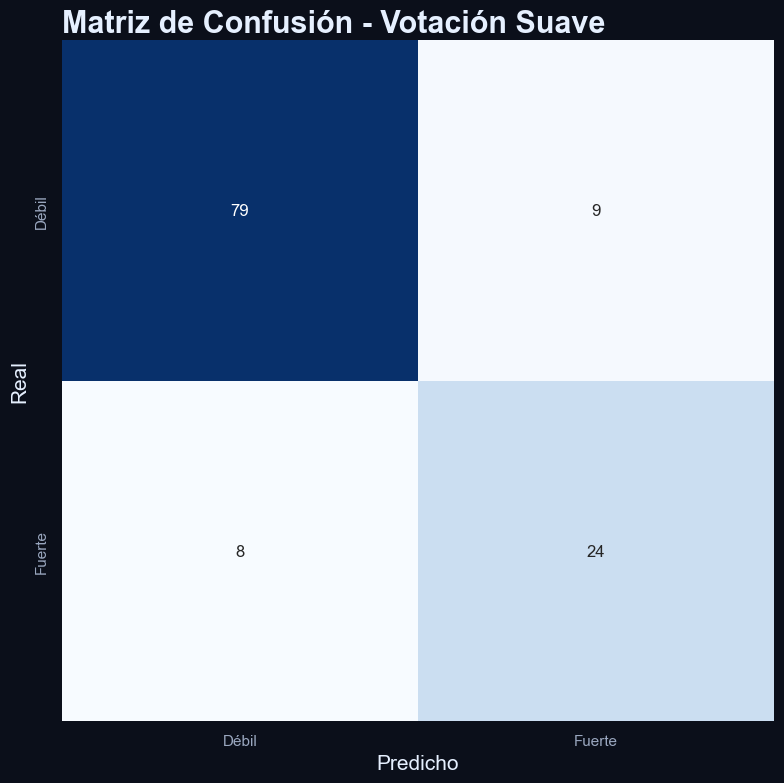

In [26]:
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix,recall_score,precision_score
def build_model_with_soft_vote(X_train, y_train):
    pre = make_preprocessor()
    models = build_models(pre)
    train_models(models, X_train, y_train)
    return lambda X: soft_vote(predict_probas(models, X))
df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)
model_soft = build_model_with_soft_vote(
    df_train[features], df_train[target]
)
y_pred_test = model_soft(df_test[features])
acc = accuracy_score(df_test[target], y_pred_test)
f1 = f1_score(df_test[target], y_pred_test)
cm = confusion_matrix(df_test[target], y_pred_test)
recall = recall_score(df_test[target], y_pred_test)
precision = precision_score(df_test[target], y_pred_test)
print(f"Desempeño del modelo con votación suave en el conjunto de prueba:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
plt.figure(figsize=(8,8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Débil", "Fuerte"],
    yticklabels=["Débil", "Fuerte"],
    cbar=False
)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Votación Suave")
plt.show()

### Generación dataset de predicción

In [27]:
test = pd.read_csv(PATH_TEST)
y_pred = model_soft(test[features])
output = {
    'id': test['id'],
    'strong': y_pred,
    'Lucario': [pd.NA] * len(test),
    'VotacionPonderada' : [pd.NA] * len(test)
}
df_output = pd.DataFrame(output)
df_output.to_csv("predicciones_finales.csv", index=False)
df_output.head()

,id,strong,Lucario,VotacionPonderada
0,894,1,<NA>,<NA>
1,981,1,<NA>,<NA>
2,755,0,<NA>,<NA>
3,73,0,<NA>,<NA>
4,931,0,<NA>,<NA>


## Cuestionario teórico

1. ¿Qué ventajas ofrece combinar varios clasificadores mediante un sistema de votación

> La gran ventaja de hacer una elección por votos es que conseguimos una decisión final la cual es mucho más sólida y confiable. Como juntamos varios modelos, el ensamble disminuye la varianza de cada uno cuando solo se consideran individualmente y, como resultado, mejora bastante su habilidad para generalizar.

2. Explica la diferencia conceptual entre votación dura y votación suave

- Votación Dura: Funciona como una votación clásica. Cada modelo da su voto por una clase específica y simplemente gana aquella que obtenga más votos.
- Votación Suave: Aquí se implementa una confianza ya que se considera qué tan "seguro" está cada modelo de su predicción. Aquí cada modelo comparte una probabilidad junto con su decisión. Luego, todas esas probabilidades se promedian, y la clase ganadora es la que termine con el promedio más alto.

3. ¿Qué tipo de problemas puede presentar una votación por mayoría simple?

> El problema más grande es que trata a todos los clasificadores como si fueran igual de buenos, cuando en realidad no siempre es así. Al tener un modelo excelente y dos modelos regulares puede que los malos ganen. En una votación por mayoría, esos dos modelos mediocres pueden "ganarle" al bueno y terminar eligiendo la respuesta incorrecta.

4. ¿En qué casos un ensamble puede tener peor desempeño que un modelo individual?

> Esto puede pasar cuando los modelos combinados cometen exactamente los mismos tipos de errores. Si todos los modelos se equivocan en la misma predicción, el ensamble no hace más que reforzar ese error en lugar de corregirlo. También sucede si la mayoría de los modelos son considerablemente peores que el mejor modelo trabajando solo.

5. ¿Por qué es importante la diversidad entre los modelos base en un ensamble?

> Con la anterior pregunta, se tiene que la diversidad es importante porque necesitamos que los modelos se equivoquen de maneras diferentes y no relacionadas. Si un modelo falla puede que otros logren acertar y "equilibrar" ese error. Si tenemos buena diversidad, es mucho menos probable que todos se equivoquen al mismo tiempo en la misma cosa.

6. Define el principio de independencia de alternativas irrelevantes y su relación con los sistemas de votación.

En términos sencillos, si tú prefieres la opción A sobre la B, agregar una tercera opción "irrelevante" C no debería cambiar repentinamente tu preferencia y hacer que ahora elijas B sobre A. En el contexto de ensambles, agregar un nuevo clasificador podría influir en la decisión final del conjunto.

7.	¿Qué diferencia existe entre una votación ponderada y una votación suave?

- Votación Suave: ya se mencionó, se promedia las probabilidades que dan todos los modelos, tratando la "confianza" de cada uno con la misma importancia.
- Votación Ponderada: Aquí le asignamos un peso de importancia a lo que dice cada clasificador, generalmente basándonos en qué tan bien se desempeña (por ejemplo, su exactitud). Después, calculamos un promedio ponderado de los votos (o probabilidades), lo que significa que le damos más influencia a los modelos que son más confiables.


8. ¿Cómo afecta el sesgo y la varianza de los modelos base al resultado del ensamble?

> Los ensambles de votación son fantásticos para reducir la varianza. Al promediar las predicciones de modelos que son inestables (con alta varianza), conseguimos un resultado final mucho más estable y consistente. Por otra parte, los ensambles de votación no pueden hacer mucho por reducir el sesgo. El sesgo del ensamble terminará siendo, en promedio, parecido al sesgo de los modelos individuales que lo componen. Si todos tus modelos son demasiado simples y tienen alto sesgo, el ensamble también lo tendrá.

9.	¿Qué implicaciones tiene combinar modelos que tienden a cometer los mismos errores?

> implícitamente de las anteriores preguntas, la consecuencia directa es que el ensamble no va a mejorar nada y básicamente será una pérdida de esfuerzo. Toda la idea detrás de un ensamble es que los errores que comete un modelo sean compensados por los aciertos de los demás. Si todos se equivocan de la misma manera (sin diversidad real), el ensamble simplemente va a heredar y validar esos mismos errores sin aportar ninguna mejora.


10.	 Explica por qué los métodos de ensamble no contradicen el teorema del no free lunch.

> El teorema "No Free Lunch" nos dice que ningún algoritmo de ML es universalmente superior a otro en todos los problemas. Los ensambles no van en contra de esto porque un ensamble es otro algoritmo más ( más complejo). Aunque es cierto que suelen tener muy buenos resultados en competencias, no existe ninguna garantía de que un ensamble siempre vaya a superar a un modelo individual bien ajustado cuando trabajamos con un conjunto de datos específico.